#  Решение задачи классификации при помощи пакета `torch`.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/optim.html
* https://lightning.ai/docs/torchmetrics/stable/
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
* https://www.learnpytorch.io/02_pytorch_classification/
* https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler
* https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb45
* https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
* https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b7
* https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
* https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss52

## Задачи для совместного разбора

1\. Обсудите подходы к решению задачи классификации на примере синтетического датасета.

In [48]:
import torch as th

In [49]:
n_samples = 1000
n_features = 4
X = th.randn(n_samples, n_features)
y = th.randint(0, 2, size=(n_samples, ))

In [50]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self, n_inputs: int, n_hidden: int, n_classes: int) -> None:
    super().__init__()
    self.fc1 = nn.Linear(n_inputs, n_hidden)
    self.fc2 = nn.Linear(n_hidden, n_classes)
    self.act = nn.ReLU()

  def forward(self, X: th.Tensor) -> th.Tensor:
    # X: batch x n_inputs
    out = self.fc1(X) # batch x n_hidden
    out = self.act(out) # batch x n_hidden
    # out = X.relu() # batch x n_hidden
    # out = F.relu(out) # batch x n_hidden
    out = self.fc2(out) # batch x n_classes
    return out

In [51]:
model = Net(n_inputs=X.shape[1], n_hidden=3, n_classes=2)
y_pred = model(X)
y_pred.shape

torch.Size([1000, 2])

In [52]:
y_pred.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [53]:
y.bincount()

tensor([491, 509])

In [54]:
criterion = nn.CrossEntropyLoss()
loss = criterion(y_pred, y)

In [55]:
model = Net(n_inputs=X.shape[1], n_hidden=3, n_classes=1)
y_pred = model(X)
criterion = nn.BCEWithLogitsLoss()
loss = criterion(y_pred.flatten(), y.float())

In [56]:
model = Net(n_inputs=X.shape[1], n_hidden=3, n_classes=2)
y_pred = model(X)
y_pred[:5]

tensor([[-0.2273,  0.6324],
        [ 0.0379,  0.7712],
        [-0.5844,  0.4927],
        [-0.5767,  0.3906],
        [-0.0256,  0.7007]], grad_fn=<SliceBackward0>)

In [57]:
y_pred.softmax(dim=1)

tensor([[0.2974, 0.7026],
        [0.3245, 0.6755],
        [0.2540, 0.7460],
        ...,
        [0.1526, 0.8474],
        [0.3373, 0.6627],
        [0.2756, 0.7244]], grad_fn=<SoftmaxBackward0>)

## Задачи для самостоятельного решения

In [58]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch as th
import torch.optim as optim


from torchmetrics import (
    MeanAbsoluteError, 
    MeanAbsolutePercentageError,
    MeanSquaredError,
    MeanSquaredLogError,
    Accuracy,
    Precision,
    Recall,
    F1Score)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.datasets import make_regression, make_circles

import numpy as np
import time

<p class="task" id="1"></p>

1\. Используя реализацию полносвязного слоя из `torch.nn`, решите задачу классификации. Разделите датасет на обучающую и тестовую выборку в соотношении 80% на 20%. В качестве функции потерь используйте реализацию `CrossEntropyLoss` из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`.

Используйте модель, состоящую из двух слоев:
1. Полносвязный слой с 10 нейронами;
2. Полносвязный слой с 2 нейронами.

Выведите график изменения значения функции потерь в процессе обучения. Выведите на экран значения Accuracy, Precision, Recall и F1 для обучающего и тестового множества.

Выведите на экран облако точек с цветом, соответствующим предсказаниям модели на всем датасете (и обучающей, и тестовой части).

- [ ] Проверено на семинаре


In [59]:
X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X)
y = th.LongTensor(y)

train_percentage = 0.8

train_size = int(X.shape[0]*train_percentage)
train_indices = np.random.choice(np.arange(X.shape[0]), train_size,False)
train_indices.sort()
test_indices = np.arange(X.shape[0])
test_indices[[i for i in test_indices if i not in train_indices]]
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

In [60]:
dset = TensorDataset(X_train,y_train)
loader = DataLoader(dset, batch_size=16, shuffle=True)
model = nn.Sequential(
    nn.Linear(X.shape[1], 10),
    nn.Linear(10,2)
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.005)

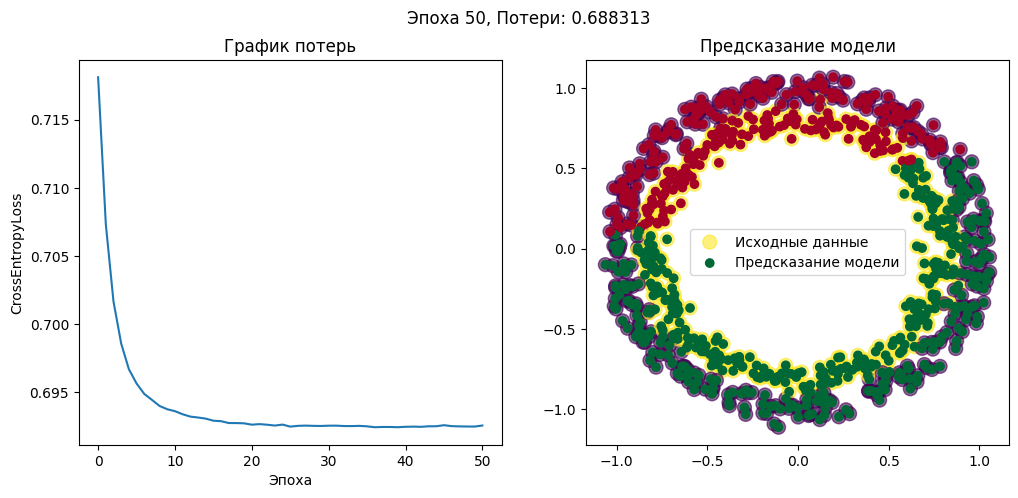

In [61]:
EPOCHS = 50
losses = []

for epoch in range(EPOCHS+1):
    e_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        e_loss+=loss.item()
    
    
    e_loss /= len(loader)
    losses.append(e_loss)
    if (epoch)%10==0:
    #     print(f'epoch {epoch+1}, loss {e_loss}')
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(losses)
        ax1.set_title("График потерь")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("CrossEntropyLoss")
        preds = th.argmax(model(X_train).softmax(dim=1), dim=1).numpy()
        # preds_colors[preds_colors==0] = 'red'
        # preds_colors[preds_colors==1] = 'green'
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1] ,c=y_train+2, label='Исходные данные', alpha=0.6, s=100)
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1],c = preds, label='Предсказание модели', cmap='RdYlGn')
        ax2.set_title("Предсказание модели")
        ax2.legend()
        
        fig.suptitle(f"Эпоха {epoch}, Потери: {loss.item():.6f}")
        
        plt.show()
    if all([i=='0' for i in str(e_loss)[2:4]]):
        break

In [ ]:
print('Train metrics')
y_final = model(X_train)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='multiclass',num_classes=2)
    print(f'{metric.__name__} = {m(y_final, y_train)}')


print('\n\nTest metrics')
y_final = model(X_test)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='multiclass',num_classes=2)
    print(f'{metric.__name__} = {m(y_final, y_test)}')

Train metrics
Accuracy = 0.5299999713897705
Precision = 0.5299999713897705
Recall = 0.5299999713897705
F1Score = 0.5299999713897705


Test metrics
Accuracy = 0.5139999985694885
Precision = 0.5139999985694885
Recall = 0.5139999985694885
F1Score = 0.5139999985694885


<p class="task" id="2"></p>

2\. Повторите задачу 1, используя другую архитектуру нейронной сети.

1. Полносвязный слой с 10 нейронами;
2. Функция активации ReLU;
3. Полносвязный слой с 2 нейронами.

- [ ] Проверено на семинаре

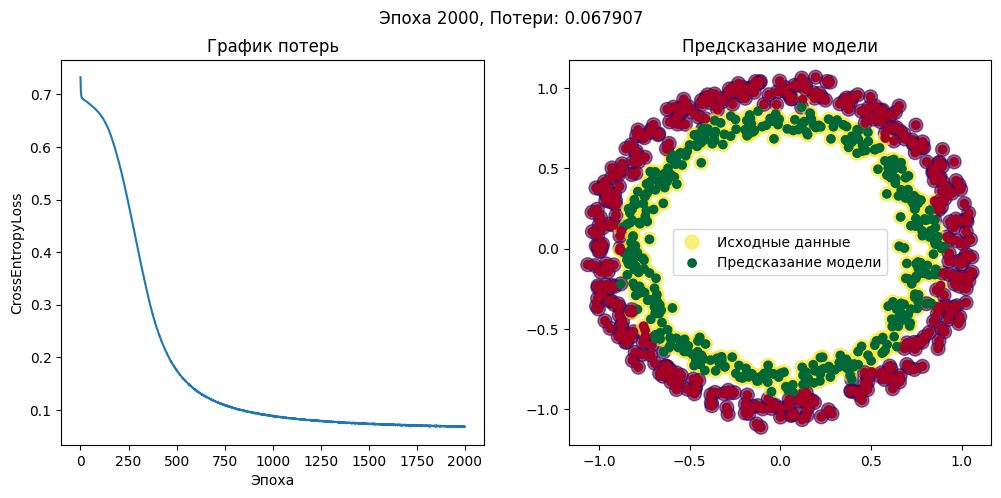

In [63]:
dset = TensorDataset(X_train,y_train)
loader = DataLoader(dset, batch_size=16, shuffle=True)
model = nn.Sequential(
    nn.Linear(X.shape[1], 10),
    nn.ReLU(),
    nn.Linear(10,2)
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.02)

EPOCHS = 2000
losses = []

for epoch in range(EPOCHS+1):
    e_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        # y_pred= th.argmax(model(X_batch).softmax(dim=1), dim=1)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        e_loss+=loss.item()
    
    
    e_loss /= len(loader)
    losses.append(e_loss)
    if (epoch)%10==0:
    #     print(f'epoch {epoch+1}, loss {e_loss}')
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(losses)
        ax1.set_title("График потерь")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("CrossEntropyLoss")
        preds = th.argmax(model(X_train).softmax(dim=1), dim=1).numpy()
        # preds_colors[preds_colors==0] = 'red'
        # preds_colors[preds_colors==1] = 'green'
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1] ,c=y_train+2, label='Исходные данные', alpha=0.6, s=100)
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1],c = preds, label='Предсказание модели', cmap='RdYlGn')
        ax2.set_title("Предсказание модели")
        ax2.legend()
        
        fig.suptitle(f"Эпоха {epoch}, Потери: {e_loss:.6f}")
        
        plt.show()
        # break
    if all([i=='0' for i in str(e_loss)[2:4]]):
        break

In [65]:
print('Train metrics')
y_final = model(X_train)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='multiclass',num_classes=2)
    print(f'{metric.__name__} = {m(y_final, y_train)}')


print('\n\nTest metrics')
y_final = model(X_test)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='multiclass',num_classes=2)
    print(f'{metric.__name__} = {m(y_final, y_test)}')

Train metrics
Accuracy = 0.9750000238418579
Precision = 0.9750000238418579
Recall = 0.9750000238418579
F1Score = 0.9750000238418579


Test metrics
Accuracy = 0.9710000157356262
Precision = 0.9710000157356262
Recall = 0.9710000157356262
F1Score = 0.9710000157356262


<p class="task" id="3"></p>

3\. `CrossEntropyLoss` может быть использована для задачи классификации на любое количество классов. Для задачи бинарной классификации существуют специфические функции потерь. Решите задачу 2, используя `BCEWithLogitsLoss` в качестве функции потерь.

- [ ] Проверено на семинаре

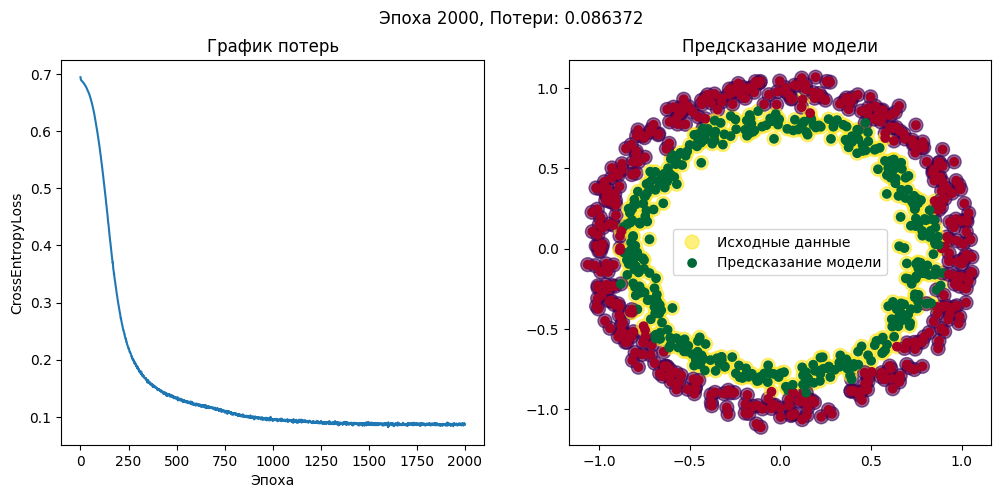

In [68]:
dset = TensorDataset(X_train,y_train)
loader = DataLoader(dset, batch_size=16, shuffle=True)
model = nn.Sequential(
    nn.Linear(X.shape[1], 10),
    nn.ReLU(),
    nn.Linear(10,1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.028)

EPOCHS = 2000
losses = []

for epoch in range(EPOCHS+1):
    e_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch).squeeze()
        # y_pred= th.argmax(model(X_batch).softmax(dim=1), dim=1)

        loss = criterion(y_pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        e_loss+=loss.item()
    
    
    e_loss /= len(loader)
    losses.append(e_loss)
    if (epoch)%10==0:
    #     print(f'epoch {epoch+1}, loss {e_loss}')
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(losses)
        ax1.set_title("График потерь")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("CrossEntropyLoss")
        
        with torch.no_grad():
            preds_logits = model(X_train).squeeze()
            preds = (torch.sigmoid(preds_logits) > 0.5).numpy()
            
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1] ,c=y_train+2, label='Исходные данные', alpha=0.6, s=100)
        ax2.scatter(X_train.numpy()[:,0],X_train.numpy()[:,1],c = preds, label='Предсказание модели', cmap='RdYlGn')
        ax2.set_title("Предсказание модели")
        ax2.legend()
        
        
        fig.suptitle(f"Эпоха {epoch}, Потери: {e_loss:.6f}")
        
        plt.show()
        # break
    if all([i=='0' for i in str(e_loss)[2:4]]):
        break

In [69]:
print('Train metrics')
y_final = model(X_train)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='binary')
    print(f'{metric.__name__} = {m(y_final.squeeze(1), y_train)}')


print('\n\nTest metrics')
y_final = model(X_test)
for metric in [   Accuracy,
    Precision,
    Recall,
    F1Score]:
    m = metric(task='binary')
    print(f'{metric.__name__} = {m(y_final.squeeze(1), y_test)}')

Train metrics
Accuracy = 0.9662500023841858
Precision = 0.9726368188858032
Recall = 0.9606879353523254
F1Score = 0.966625452041626


Test metrics
Accuracy = 0.9610000252723694
Precision = 0.965656578540802
Recall = 0.9559999704360962
F1Score = 0.9608040452003479


<p class="task" id="4"></p>

4\. На практике часто задача классификации является несбалансированной. В файлах каталога `imb_task` содержится несбалансированный набор данных. Обучите модель без учета несбалансированности классов (аналогично предыдущим заданиям, можно использовать любую подходящую функцию потерь). Повысьте качество модели (в смысле F1) путем модификации функции потерь (указания специального аргумента, позволяющего учесть несбалансированность классов).

- [ ] Проверено на семинаре

<p class="task" id="5"></p>

5\. Повторите решение задачи 4, повысив качество модели за счет использования `WeightedRandomSampler` вместо модификации функции потерь.

- [ ] Проверено на семинаре